In [ ]:
!pip install -q qiskit
!pip install -q qiskit_machine_learning
!pip install -q pylatexenc
!pip install -q qiskit-machine-learning[sparse]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import numpy as np
import math
import qiskit
from qiskit.visualization import plot_histogram

# Generate random quantum circuit states 

- Through arbitrary rotations and entangling gates

In [2]:
def normalize(d, target=1.0):
   raw = sum(d.values())
   factor = target/raw
   return {key:value*factor for key,value in d.items()}
   
def conv_resultdict_nparray(results:dict, nqubits:int) -> np.ndarray:
    """Convert quantum cirucit results (dict) into a 2D matrix
    that stores all the binary vectors.
    First we get all the strings obtained for each measurement (m) and then convert each bitstring into
    a n-column vector. Such a vector is craeted for each measurement, yielding a 2D matrix (m, n)"""
    
    result_array_str = np.concatenate([[key]*results[key] for key in results])
    result_array_vec = np.zeros((result_array_str.shape[0], nqubits))
    for rowid, row in enumerate(result_array_str):
        for colid, elem in enumerate(row):
            result_array_vec[rowid, colid] = elem

    print("Result loaded on numpy array! Output shape:",(result_array_vec.shape))
    return np.random.permutation(result_array_vec)

In [3]:
nqubits = 4
seed = 12

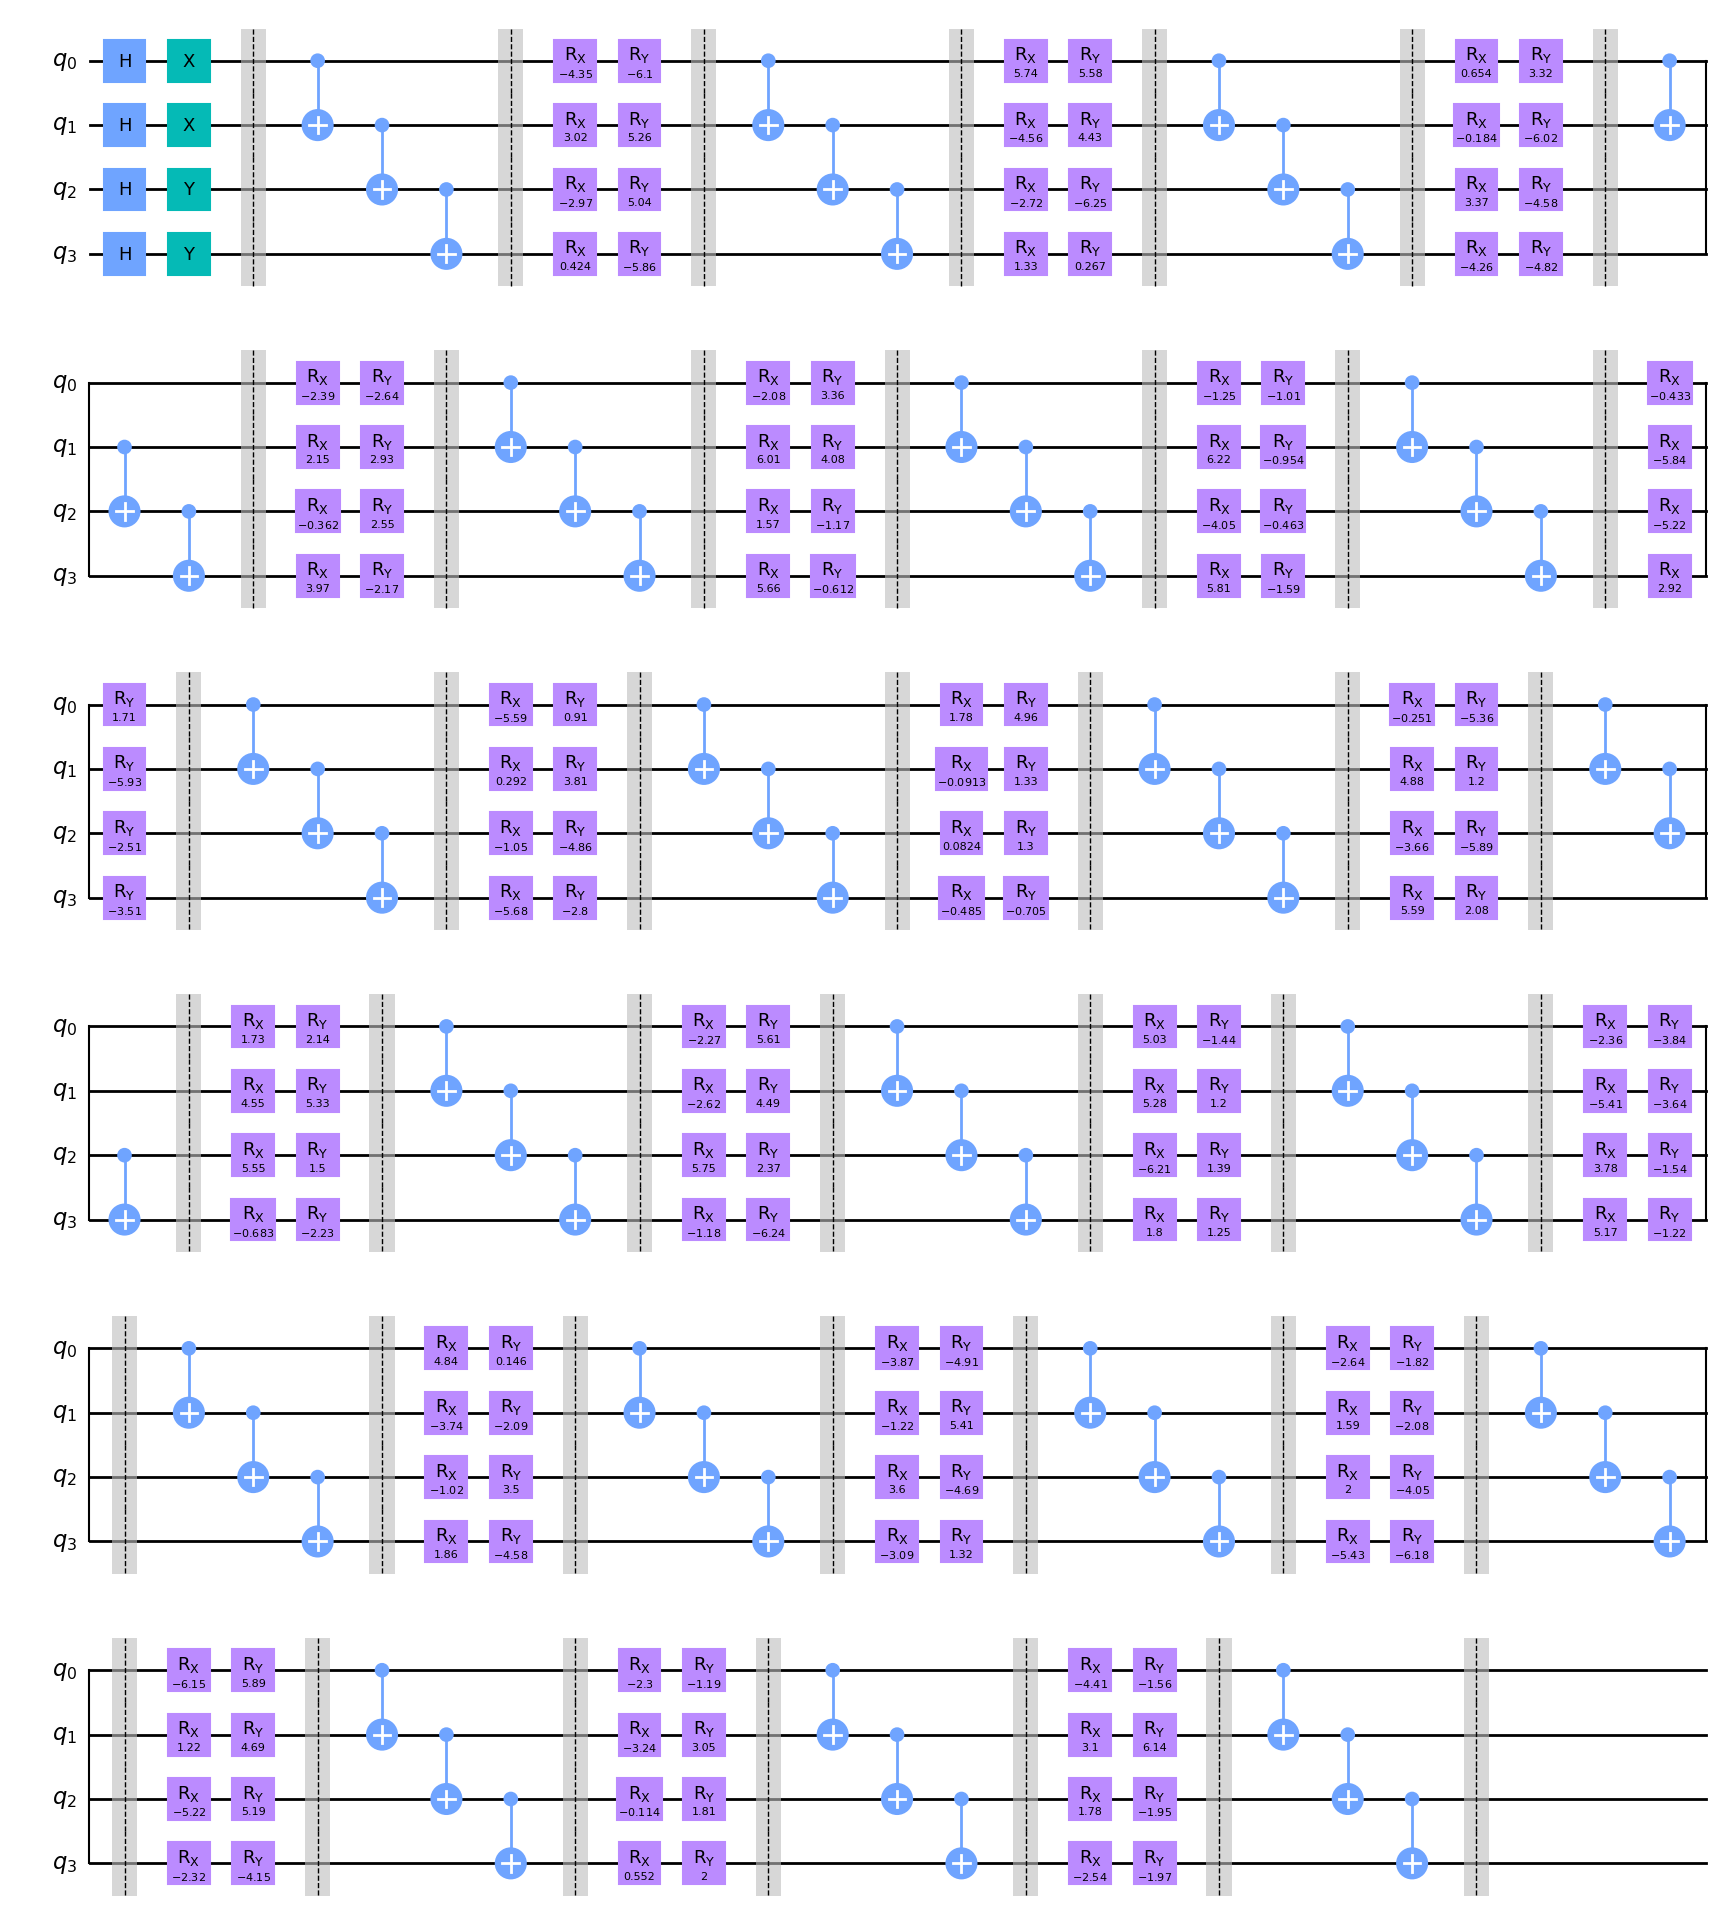

In [4]:
np.random.seed(seed)
circ_simple = qiskit.QuantumCircuit(nqubits)
circ_simple.h(range(nqubits)); 
circ_simple.x(range(nqubits//2)); circ_simple.y(range(nqubits//2, nqubits)); circ_simple.barrier()
for i in range(20):
    circ_simple.cx(range(nqubits-1), range(1,nqubits)); circ_simple.barrier()
    [circ_simple.rx(2*np.pi*(2*np.random.rand(1)[0]-1), i) for i in range(nqubits)]
    [circ_simple.ry(2*np.pi*(2*np.random.rand(1)[0]-1), i) for i in range(nqubits)] ; circ_simple.barrier()
circ_simple.cx(range(nqubits-1), range(1,nqubits)); circ_simple.barrier()
circ_simple.draw('mpl')

In [5]:
circ_simple.count_ops()

OrderedDict([('rx', 80),
             ('ry', 80),
             ('cx', 63),
             ('barrier', 42),
             ('h', 4),
             ('x', 2),
             ('y', 2)])

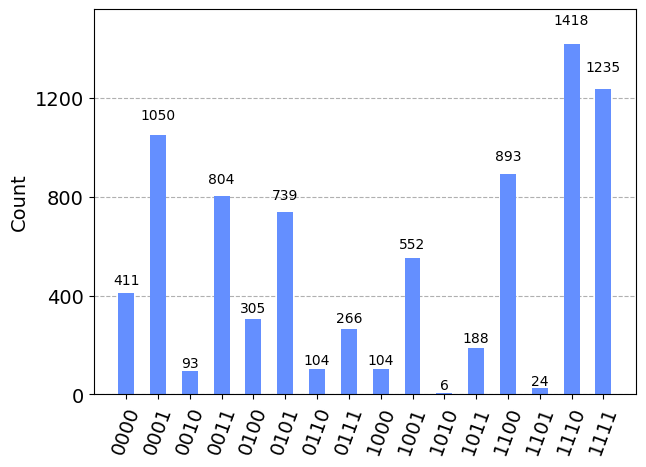

In [6]:
circ_simple.measure_all()
job = qiskit.execute(circ_simple, backend=qiskit.Aer.get_backend('qasm_simulator'),
                     shots=pow(2,13))
results = job.result().get_counts()
plot_histogram(results)

In [7]:
outputfile = conv_resultdict_nparray(results, nqubits) #np.random.permutation(result_array_vec)
outputfile

Result loaded on numpy array! Output shape: (8192, 4)


array([[1., 1., 1., 0.],
       [0., 0., 0., 1.],
       [1., 1., 1., 0.],
       ...,
       [1., 1., 1., 1.],
       [0., 1., 0., 1.],
       [1., 1., 0., 0.]])

In [8]:
n_samples = outputfile.shape[0]
n_samples

8192

# Creating a QeVAE

In [9]:
import time
import qiskit
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.connectors import TorchConnector

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [10]:
results

{'0010': 93,
 '1101': 24,
 '0000': 411,
 '0100': 305,
 '1100': 893,
 '1110': 1418,
 '1001': 552,
 '0101': 739,
 '0111': 266,
 '0011': 804,
 '1011': 188,
 '0001': 1050,
 '1111': 1235,
 '1010': 6,
 '1000': 104,
 '0110': 104}

In [11]:
original_results = normalize(results)
original_results

{'0010': 0.0113525390625,
 '1101': 0.0029296875,
 '0000': 0.0501708984375,
 '0100': 0.0372314453125,
 '1100': 0.1090087890625,
 '1110': 0.173095703125,
 '1001': 0.0673828125,
 '0101': 0.0902099609375,
 '0111': 0.032470703125,
 '0011': 0.09814453125,
 '1011': 0.02294921875,
 '0001': 0.128173828125,
 '1111': 0.1507568359375,
 '1010': 0.000732421875,
 '1000': 0.0126953125,
 '0110': 0.0126953125}

In [12]:
vals = np.array(list(normalize(results).values()))
#nqubits = datafile.shape[1]
fidelity_uniform_sqrt = np.sum(np.sqrt(vals*(1/pow(2, nqubits))))
print("Fidelity with a uniform distribution:", fidelity_uniform_sqrt**2)

Fidelity with a uniform distribution: 0.7776713092483614


## Create measurement dataloaders

In [13]:
class MeasurementDataset(Dataset):

    def __init__(self, numpy_array:np.ndarray):
        # dataloading
        self.x = torch.from_numpy(numpy_array[:,:])
        self.num_samples = numpy_array.shape[0]


    def __getitem__(self, index):
        # dataset[0]
        return self.x[index].float()

    def __len__(self):
        # len(dataset)
        return self.num_samples

In [29]:
# Setup training and testing datasets

want_datasetsize= 0.05  # can change to 0.2
train_size = 0.75
training_dataset = MeasurementDataset(outputfile[: int(want_datasetsize*train_size * n_samples)])
valid_dataset = MeasurementDataset(outputfile[int(want_datasetsize*train_size * n_samples) : int(want_datasetsize * n_samples)])

train_dataloader = DataLoader(
    training_dataset, batch_size=1, shuffle=True, num_workers=1
)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=True, num_workers=1)

dataloaders = [train_dataloader, valid_dataloader]
dataloader_info = "Size of training set: %d | Size of validation set: %d"% (len(train_dataloader), len(valid_dataloader))
print(dataloader_info)

Size of training set: 307 | Size of validation set: 102


# Setup model

## Create model

In [15]:
def create_qnn(num_inputs: int, num_qubits: int, qc_params: dict):
    """Creates the decoder circuit with ansatz"""

    if num_inputs > num_qubits:
        raise ValueError(
            "Number of inputs is greater than the number of qubits... Not suitable with current feature map"
        )

    fm, entanglement_type, repititions = qc_params.values()

    if fm == "ZZ":
        feature_map = qiskit.circuit.library.ZZFeatureMap(num_inputs)
    elif fm == "Z":
        feature_map = qiskit.circuit.library.ZFeatureMap(num_inputs)
    elif fm == 'P':
        feature_map = qiskit.circuit.library.PauliFeatureMap(num_inputs, reps=1, paulis=['X', 'Y'],
                                                             insert_barriers=True)
    else:
        raise ValueError("Wrong feature Map provided!")

    # local_entanglement = {}
    ansatz = qiskit.circuit.library.TwoLocal(
        num_qubits=num_qubits,
        rotation_blocks=["ry", "rx"],
        entanglement_blocks="cx",
        skip_final_rotation_layer=False,
        entanglement=entanglement_type,
        reps=repititions,  # 1
        insert_barriers=True,
    )
    qc = qiskit.QuantumCircuit(num_qubits)
    qc.append(feature_map, range(0, num_inputs))
    qc.h(range(num_inputs, num_qubits)) if num_inputs < num_qubits else None
    qc.barrier()
    qc.append(ansatz, range(num_qubits))
    qnn = CircuitQNN(
        qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
        sparse=False,
        quantum_instance=qiskit.Aer.get_backend("qasm_simulator"),
    )
    return qnn, qc

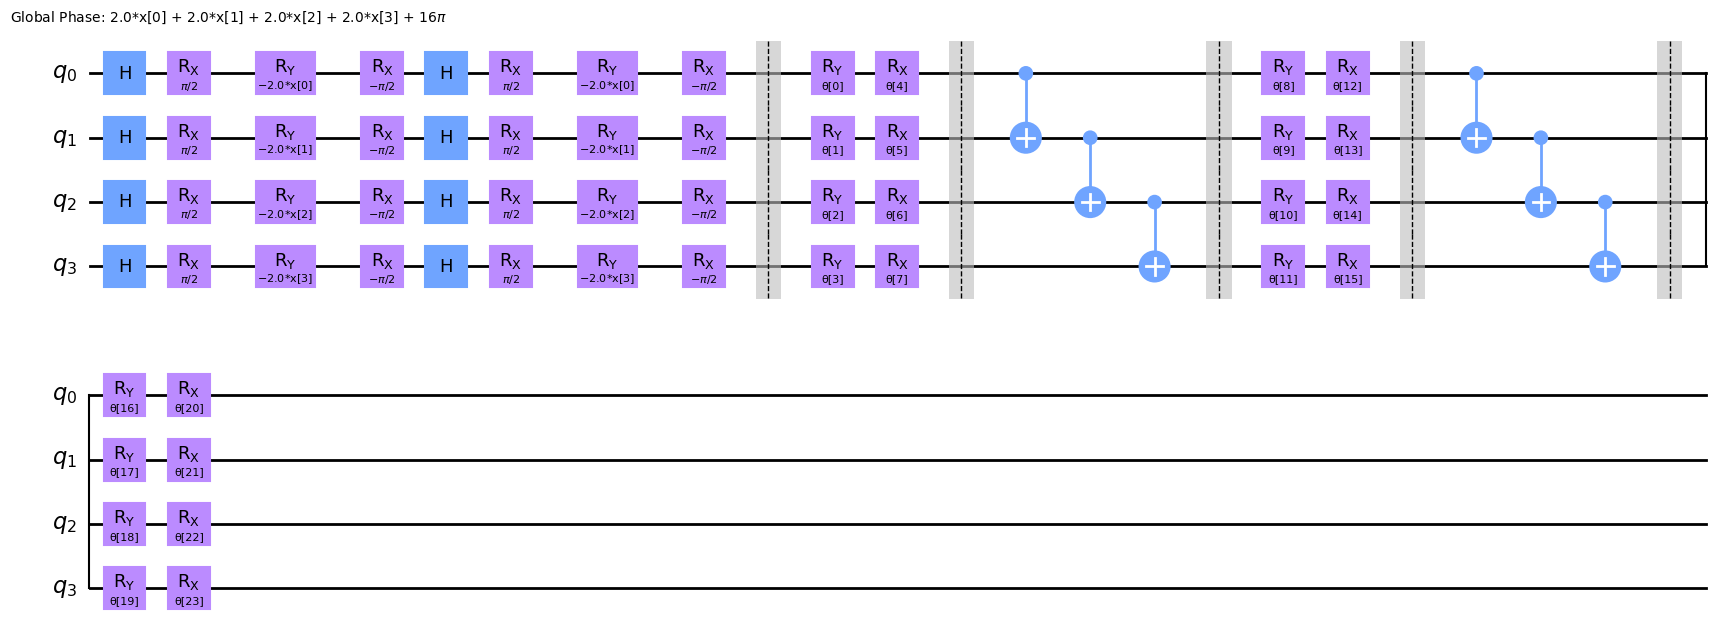

In [30]:
qnn_sample, qnn_qc_sample = create_qnn(num_inputs=4, num_qubits=4, qc_params= {'fm':'Z',
                                                                 'entanglement_type':'linear',
                                                                  'repititions':2})
tc_qc_sample = qiskit.transpile(qnn_qc_sample, basis_gates=['h','rx','ry','cx'])
                                
tc_qc_sample.draw('mpl')

In [17]:
print("Original circuit number of operations: ", circ_simple.count_ops())
print("Ansatz circuit number of operations: ", tc_qc_sample.count_ops())

Original circuit number of operations:  OrderedDict([('rx', 80), ('ry', 80), ('cx', 63), ('barrier', 43), ('h', 4), ('measure', 4), ('x', 2), ('y', 2)])
Ansatz circuit number of operations:  OrderedDict([('rx', 28), ('ry', 20), ('h', 8), ('cx', 6), ('barrier', 5)])


In [18]:
class QVAE_qcompile(torch.nn.Module):

    def __init__(self, qnn, latent_dim:int):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(qnn.circuit.num_qubits, 8),
            torch.nn.LeakyReLU(0.01),
            torch.nn.Linear(8, 7),
            torch.nn.LeakyReLU(0.01)) 

        self.z_mean = torch.nn.Linear(7,latent_dim)
        self.z_log_var = torch.nn.Linear(7,latent_dim)

        # self.preprocessor = torch.nn.Sequential(
        #     torch.nn.Linear(latent_dim, qnn.circuit.num_qubits),
        #     torch.nn.LeakyReLU(0.01))
        
        self.preprocessor = torch.nn.Linear(latent_dim, qnn.circuit.num_qubits)
        torch.nn.init.normal_(self.preprocessor.weight, mean=0, std=0.01)
        torch.nn.init.constant_(self.preprocessor.bias, val=0)
            
        self.decoder = TorchConnector(qnn)

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded
        
    def decoding_fn(self, x):
        x = self.preprocessor(x)
        decoded = self.decoder(x)
        return decoded
        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1))
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        preprocessed = self.preprocessor(encoded)
        decoded = self.decoder(preprocessed)
        return encoded, z_mean, z_log_var, decoded #preprocessed

In [19]:
class Decoder_distribution():
    """Get distribution by sampling latent space of classial or quantum VAE"""

    def __init__(self, model, original_results:dict, nn_type:str, nsamples:int):
        self.model = model
        self.original_results = normalize(original_results) # set sum frequency = 1
        self.nsamples = nsamples
        self.nn_type = nn_type

    def get_outputstate_from_latentspace_CVAE(self) -> str:
        """For classical VAE: Sample from normal(0,1) from latent space and provide a single
        output bitstring"""
        
        self.model.eval()
        with torch.no_grad():
            sample = torch.randn(self.model.z_mean.out_features) # inputs go through preprocessor
            output = self.model.decoding_fn(sample)
            p = torch.rand(output.shape) #np.random.rand(1)[0]
            state = torch.where(output>p, 1, 0)   
            bitstring = np.apply_along_axis("".join, 0, state.numpy().astype(int).astype(str))
        return bitstring

    def get_ouputdict_from_bitstrings(self, output_dict:dict, bitstring:str) -> dict:
        """If Bitstring is present in output dict then increase count by 1, 
        otherwise create new key"""
        if bitstring.item() in output_dict.keys():
            output_dict[bitstring.item()] += 1
        else:
            output_dict[bitstring.item()] = 1
            #print(bitstring.item())
        return output_dict

    def get_decoder_dist_QVAE(self):
        """For QVAE: Sample from latent space and return marginalised distribution"""
        nqubits = self.model.encoder[0].in_features
        outputs = np.zeros(( self.nsamples, pow(2, nqubits) ))
        with torch.no_grad():
            for idx, _ in enumerate(outputs):
                sample = torch.randn(self.model.z_mean.out_features)
                outputs[idx, :] = self.model.decoding_fn(sample)
        outputs = outputs.mean(axis=0) 
        bitstring_basis = [("{0:0%db}"%nqubits).format(i) for i in range(pow(2, nqubits))]

        return dict(zip(bitstring_basis, outputs))

    def get_fidelity(self, model_output_dict:dict) -> float:
        """Get Bhattacharya co-efficienct of two discrete distributions. 
        The two distributions are normalized (sum of frequencies set to 1) before computation"""
        fidelity_sqrt = 0
        for key in self.original_results.keys():
            if key in model_output_dict.keys():
                fidelity_sqrt += np.sqrt(self.original_results[key]*model_output_dict[key])
        return fidelity_sqrt**2

    def get_no_wrong_samples(self, model_output_dict:dict) -> float:
        """Get the number of wrong samples from the learnt distribution and the mass on right samples
        Wrong sample: bitstring that is not in original_results and has positive probability in learnt distribution"""
        wrong_samples = 0
        for basis_state in model_output_dict.keys():
            if (basis_state not in self.original_results) & (model_output_dict[basis_state] != 0):
                wrong_samples += 1 
        return wrong_samples

    def get_mass_rightsamples(self, model_output_dict:dict) -> float:
        """Get mass of right samples
        Sum of masses in learnt distribution that is on the basis seen in the original dist"""
        mass_right_samples = 0
        for basis_state in self.original_results:
            if basis_state in model_output_dict.keys():
                mass_right_samples += self.original_results[basis_state]
        return mass_right_samples

    def get_decoder_distribution(self):
        """Get distribution from decoder"""
        #output_states = np.zeros((self.nsamples, self.model.decoder[0].in_features))
        
        with torch.no_grad():
            if self.nn_type == "classical":
                output_dict = {}
                for i in range(self.nsamples):
                    bitstring = self.get_outputstate_from_latentspace_CVAE()
                    output_dict = self.get_ouputdict_from_bitstrings(output_dict, bitstring)
                
            elif self.nn_type == "quantum-classical":
                output_dict = self.get_decoder_dist_QVAE()
        
        output_dict = normalize(output_dict)
        no_wrong_samples = self.get_no_wrong_samples(output_dict)
        mass_right_samples = self.get_mass_rightsamples(output_dict)
        fidelity = self.get_fidelity(output_dict)
        return output_dict, no_wrong_samples, mass_right_samples, fidelity 

## Setup training loop

In [32]:
# Set simulation parameters

nqubits=4
featuremap = "P"
patience = 7
minibatchsize=32
beta = 1
latentsize=4
annealing_schedule = 'fixed' # stepfn, linear, fixed, zero, stepfn_linear
nn_type= "quantum-classical" # quantum-classical, classical

encoder_lr = 0.004; decoder_lr = 0.009
learning_rates = [encoder_lr, decoder_lr]

num_epochs = 50
# root_dir = os.path.join(project_dir, "log-files/Quantumcircuit-states")
# print(true_results)

In [40]:
model = QVAE_qcompile(qnn_sample, latent_dim=4)

In [41]:
optimizer = torch.optim.Adam(
    [
        {"params":model.encoder.parameters(), "lr":encoder_lr},
     {"params":model.z_mean.parameters(), "lr":encoder_lr}, 
    {"params":model.z_log_var.parameters(), "lr":encoder_lr},
    {"params":model.preprocessor.parameters(), "lr":encoder_lr},
    {"params":model.decoder.parameters(), "lr":decoder_lr}
])

In [43]:
# Print number of trainable parameters
encoder_trainable_params = sum(
    p.numel() for p in model.encoder.parameters() if p.requires_grad
)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

trainparams_info = "No of trainable parameters: \n (Model:%d) | (Encoder:%d) | (Decoder:%d)"%(trainable_params,
                                                                                              encoder_trainable_params,
                                                                                              qnn_sample.num_weights)
epoch_batch_info = "Total number of epochs: %d | Total number of batches: %d"%(num_epochs,
                                                                               math.ceil(len(dataloaders[0])/minibatchsize))

print(trainparams_info,'\n',epoch_batch_info)

No of trainable parameters: 
 (Model:211) | (Encoder:103) | (Decoder:24) 
 Total number of epochs: 50 | Total number of batches: 10


### Start training

In [44]:
logdict = {"train_combined_loss_per_minibatch": [],
            "train_reconstruction_loss_per_minibatch": [],
            "train_kl_loss_per_minibatch": [],
            "valid_reconstruction_loss": []}

all_bitstrings = [("{0:0%db}"%nqubits).format(i) for i in range(pow(2, nqubits))]
output_qubits = 4

decoder_params_list = []
no_wrong_samples,right_samples_mass,output_dict_list, fidelity_list = [],[],[],[]

In [45]:
def validation_loss(model, valid_dataloader, all_bitstrings):

    output_qubits = model.encoder[0].in_features
    total_val_loss = 0

    with torch.no_grad():
        for idx, data in enumerate(valid_dataloader):
            encoded, z_mean, z_log_var, decoded = model(data)
            input_bitstring = np.apply_along_axis("".join, 1, data.detach().numpy().astype(int).astype(str))
            meas_dict = dict(zip(all_bitstrings,(decoded.squeeze() + pow(2, -18))/ (1 + pow(2, -18) * pow(2, output_qubits)),))
            likelihood_losses = -torch.log(meas_dict[input_bitstring[0]])
            total_val_loss += likelihood_losses

        return total_val_loss / len(valid_dataloader)

In [46]:
loss_list = []

# Early stopping
last_loss = 20
init_mass_rightsamples = 0
trigger_times = 0

for epoch in range(num_epochs):
    total_loss = []
    epoch_kl_loss = []
    epoch_mse_loss = []

    kl_term_weight = beta
    minibatchsize_no = 0
    start_time = time.time()

    for batch_idx, data in enumerate(train_dataloader):

        # Forward pass
        encoded, z_mean, z_log_var, decoded = model(data)
        input_bitstring = np.apply_along_axis("".join, 1, data.numpy().astype(int).astype(str))
        measurement_dict = dict(zip(all_bitstrings,(decoded.squeeze() + pow(2, -18))
                            / (1 + pow(2, -18) * pow(2, output_qubits)),))
        likelihood_losses = -torch.log(measurement_dict[input_bitstring[0]])

        # Normalize loss for batch accumulation
        mean_ll = likelihood_losses / minibatchsize
        kl_loss = -0.5 * torch.sum(
            1 + z_log_var - z_mean ** 2 - torch.exp(z_log_var)
        )
        kl_loss = (kl_term_weight * kl_loss) / minibatchsize
        loss = mean_ll + kl_loss

        # Backward pass
        loss.backward()

        # weights update
        if ((batch_idx + 1) % minibatchsize == 0) or (batch_idx + 1 == len(train_dataloader)):
            minibatchsize_no += 1
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)  # reset gradients to zero

            # Store losses
            total_loss.append(loss.item())
            epoch_mse_loss.append(mean_ll.item())
            epoch_kl_loss.append(kl_loss.item())

            print(
                "(%d|%d , %d|%d) Total loss: %.5f | Likelihood loss: %.5f | KL loss : %.5f "
                % (epoch + 1,num_epochs,minibatchsize_no,
                    math.ceil(len(train_dataloader) /minibatchsize),
                    loss.item(),mean_ll.item(),kl_loss.item(),))

            # LOGGING
            logdict["train_combined_loss_per_minibatch"].append(loss.item())
            logdict["train_reconstruction_loss_per_minibatch"].append(mean_ll.item())
            logdict["train_kl_loss_per_minibatch"].append(kl_loss.item())

    end_time = time.time()
    valid_loss = validation_loss(model, valid_dataloader, all_bitstrings)
    logdict["valid_reconstruction_loss"].append(valid_loss)


    decoder_params = model.decoder.weight.detach().numpy().copy()
    encoder_params = [param.detach().numpy().tolist() for param in model.encoder.parameters()]
    decoder_params_list.append(decoder_params)

    output_dist = Decoder_distribution(model, original_results, nn_type='quantum-classical', nsamples=5000)
    (output_dict,n_wrong_samples,mass_right_samples,fidelity) = output_dist.get_decoder_distribution()

    no_wrong_samples.append(n_wrong_samples)
    right_samples_mass.append(mass_right_samples)
    output_dict_list.append(output_dict)
    fidelity_list.append(fidelity)
    print("Fidelity:", fidelity)

    # Store loss for epoch
    loss_list.append(sum(total_loss) / len(total_loss))

    print("Time taken %4fs" % (end_time - start_time))
    print("Epoch: %02d/%02d | Beta %.3f | Avg Train Loss: %.4f | Valid Loss: %.4f | Wrong states: %d | Mass on right states %.4f\n"
        %(epoch + 1,num_epochs,kl_term_weight,loss_list[-1],
            valid_loss,n_wrong_samples,mass_right_samples,))

    if valid_loss > last_loss:  # mass_right_samples < init_mass_rightsamples:
        trigger_times += 1
        #trigger_vals.append(trigger_times)
        print(f"Trigger Times: {trigger_times} \n")

        if trigger_times >= patience:
            print("Early stopping! Closing training. Now can start to test process.")
            break
        
    elif valid_loss <= last_loss:  
        # mass_right_samples >= init_mass_rightsamples:
        print("Trigger times: 0\n")
        trigger_times = 0
        last_loss = valid_loss

(1|50 , 1|10) Total loss: 0.09092 | Likelihood loss: 0.08429 | KL loss : 0.00663 
(1|50 , 2|10) Total loss: 0.08625 | Likelihood loss: 0.07852 | KL loss : 0.00773 
(1|50 , 3|10) Total loss: 0.07048 | Likelihood loss: 0.06426 | KL loss : 0.00622 
(1|50 , 4|10) Total loss: 0.07066 | Likelihood loss: 0.06474 | KL loss : 0.00592 
(1|50 , 5|10) Total loss: 0.06944 | Likelihood loss: 0.06379 | KL loss : 0.00565 
(1|50 , 6|10) Total loss: 0.07938 | Likelihood loss: 0.07397 | KL loss : 0.00540 
(1|50 , 7|10) Total loss: 0.09723 | Likelihood loss: 0.09195 | KL loss : 0.00528 
(1|50 , 8|10) Total loss: 0.07495 | Likelihood loss: 0.06972 | KL loss : 0.00523 
(1|50 , 9|10) Total loss: 0.11279 | Likelihood loss: 0.10830 | KL loss : 0.00448 
(1|50 , 10|10) Total loss: 0.09612 | Likelihood loss: 0.09195 | KL loss : 0.00417 
Fidelity: 0.8136439071616353
Time taken 139.372164s
Epoch: 01/50 | Beta 1.000 | Avg Train Loss: 0.0848 | Valid Loss: 2.7864 | Wrong states: 0 | Mass on right states 1.0000

Trigge

In [48]:
import matplotlib.pyplot as plt

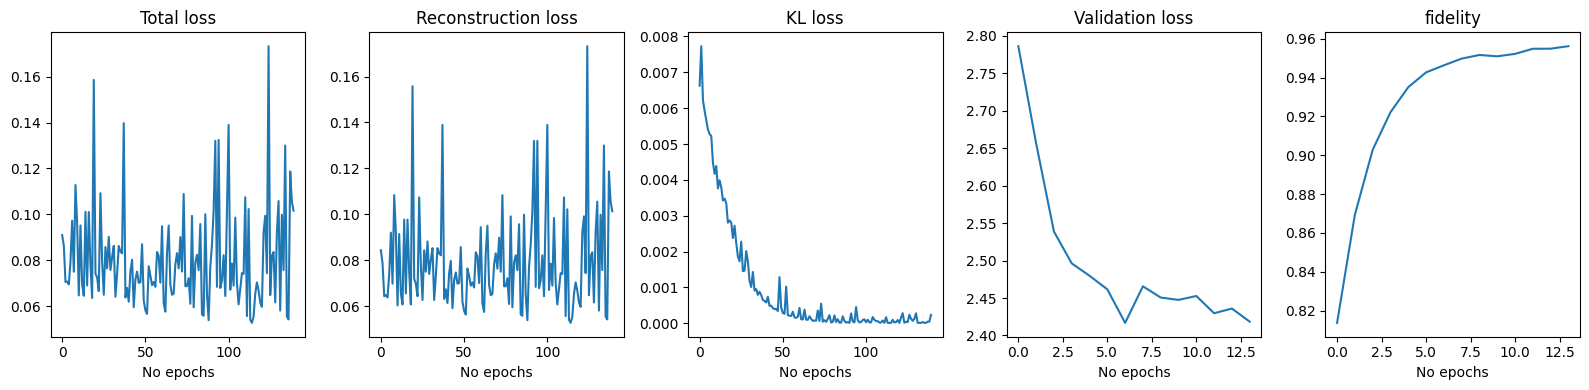

In [59]:
fig, ax = plt.subplots(1, 5, figsize=(16,4))

titles=['Total loss', 'Reconstruction loss', 'KL loss', 'Validation loss']
for idx, (key, value) in enumerate(logdict.items()):
    ax[idx].plot(value)
    ax[idx].set(title=titles[idx], xlabel="No epochs")

ax[4].plot(fidelity_list)
ax[4].set(title="fidelity", xlabel="No epochs")

plt.tight_layout()
plt.show()

In [86]:
n_samples = 1000
random_samples = torch.randn(n_samples, 4)
output_dist = np.zeros((n_samples, pow(2,4)))

for idx, sample in enumerate(random_samples):
    with torch.no_grad():
        processed_sample = model.preprocessor(sample)
        output_dist[idx, :] = model.decoder(processed_sample)

In [72]:
original_results

orig_dist_sorted = []
for bitstring in all_bitstrings:
    orig_dist_sorted.append(original_results[bitstring])

In [88]:
final_fidelity = 0
for idx in range(16):
    final_fidelity += np.sqrt(orig_dist_sorted[idx]*output_dist.mean(axis=0)[idx])
final_fidelity = final_fidelity**2

print("Learnt distribution fidelity:", final_fidelity)

Learnt distribution fidelity: 0.9560137098061083


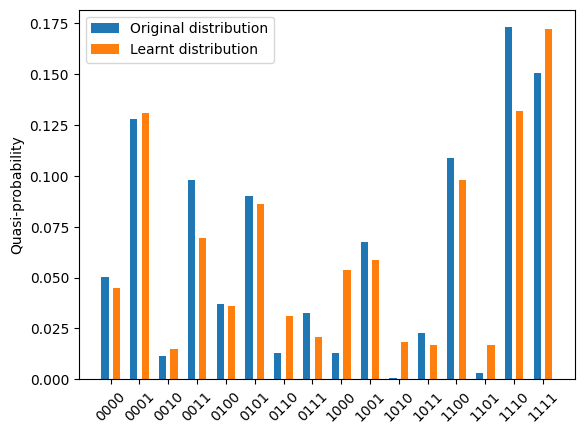

In [93]:
plt.bar(np.arange(16)-0.2, orig_dist_sorted, width=0.25, label="Original distribution")
plt.bar(np.arange(16)+0.2, output_dist.mean(axis=0), width=0.25, label="Learnt distribution")

plt.legend()
plt.xticks(np.arange(16), all_bitstrings, rotation=45)
plt.ylabel("Quasi-probability")
plt.show()

In [95]:
# The parameters of the ansatz the yield the same measurement distribution are: 
list(model.decoder.parameters())


[Parameter containing:
 tensor([ 0.1134, -0.3563,  0.8788,  0.3221,  0.2348,  0.1832, -0.7226,  0.6454,
          1.1179,  1.0798, -0.5304,  0.0228, -0.0793,  0.5012, -0.8265, -0.6679,
          0.8516, -1.3744,  0.2859, -0.4702, -0.4697,  0.9904, -0.6444, -1.1075],
        requires_grad=True)]